In [113]:
import numpy as np
import pandas as pd
import scipy.optimize as opt
import matplotlib.pyplot as plt
import seaborn as sns
# %matplotlib inline

In [304]:
# def ll4(x,b,c,d,e):
#     '''This function is basically a copy of the LL.4 function from the R drc package with
#      - b: hill slope
#      - c: min response
#      - d: max response
#      - e: EC50'''
#     return (c+(d-c)/(1+np.exp(b*(np.log(x)-np.log(e)))))


def ll4(conc, h, IC50):
    # print(conc)
    '''This function is basically a copy of the LL.4 function from the R drc package with
     - h: hill slope
     - a: min response
     - b: max response
     - IC50: IC50'''
    # return a+(b-a)/(1+np.exp(h*(np.log(conc)-np.log(IC50))))
    return 100.0/(1+(conc/IC50)**h)



def pDose(x):
    '''This is just a helper function, to compute easily log transformed concentrations used in drug discovery'''
    return(-np.log10(1e-6*x))

### Generating data

In [305]:
doses = np.append(np.arange(1,11), [15, 20, 25], axis=0)
# doses = np.arange(1, 100)
cmax = 2
concs = doses*cmax
concs

array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20, 30, 40, 50])

In [306]:
params = [
    { 'compound': 'diltiazem',  'h': 0.714205489,   'IC50': 112.1303862 },
    # { 'compound': 'A',  'b': 1,    'c': 0,   'd': 100,  'e': 0.4,   'startDose': 10,  'nDose': 8,  'dilution': 3 },
    # { 'compound': 'B',  'b': 0.7,  'c': 0,   'd': 86,   'e': 1.3,   'startDose': 30,  'nDose': 8,  'dilution': 3 },
    # { 'compound': 'C',  'b': 2,    'c': 24,  'd': 152,  'e': 0.02,  'startDose': 3,   'nDose': 8,  'dilution': 3 }
]

# dilution 

In [307]:
len(rep.response)

13

In [308]:
np.random.normal(len(rep.response)) 

13.477373857272662

In [309]:
drData=[]
for curve in params:        
    
    # generate base curve
    curData = pd.DataFrame(
        data={
            'compound':curve['compound'], 
            # 'dose':curve['startDose']/np.power(curve['dilution'], range(curve['nDose']))
            'dose': concs
        }        
    )    
    
    curData['logDose'] = pDose(curData.dose)
    curData['response'] = curData.dose.apply(lambda x: ll4(x,*[curve[i] for i in ['h', 'IC50']]))        
    
    # generate replicates
    repData = []
    for i in range(3):
        rep = copy.deepcopy(curData)
        if i>0 and i%2==1:            
            rep.response -= 0.25*np.random.normal(len(rep.response))                    
        elif i>0 and i%2==0:            
            rep.response += 0.25*np.random.normal(len(rep.response))        
        # for j in range(len(rep.response)):
        #     if rep.response[j] >100:
        #         rep.response[j] = 100
        # print(rep.response)
        repData.append(rep.copy())    
    repData = pd.concat(repData)    
    drData.append(repData)    
# assemble data
drData = pd.concat(drData)

drData.head(13)

,compound,dose,logDose,response
0,diltiazem,2,5.698970,94.663504
1,diltiazem,4,5.397940,91.534445
2,diltiazem,6,5.221849,89.003751
3,diltiazem,8,5.096910,86.825992
4,diltiazem,10,5.000000,84.893724
5,diltiazem,12,4.920819,83.146907
6,diltiazem,14,4.853872,81.547406
7,diltiazem,16,4.795880,80.068972
8,diltiazem,18,4.744727,78.692511
9,diltiazem,20,4.698970,77.403559


In [328]:
compoundData = drData.groupby(['compound'])
fitData = []
for name,group in compoundData:
    fitCoefs, covMatrix = opt.curve_fit(ll4, group.dose, group.response, p0=(0.5, 100), bounds=([0, 1e-10], [10, 1e+10]), method='trf')
    print(fitCoefs)
    resids = group.response-group.dose.apply(lambda x: ll4(x,*fitCoefs))
    curFit = dict(zip(['h', 'IC50'], fitCoefs))
    curFit['compound']=name
    curFit['residuals']=sum(resids**2)
    fitData.append(curFit)
fitCompound = [ item['compound'] for item in fitData]
fitCompound

[  0.7189244  112.45663074]


['diltiazem']

In [329]:
fitTable = pd.DataFrame(fitData).set_index('compound')
fitTable

,h,IC50,residuals
compound,,,
diltiazem,0.718924,112.456631,238.877807


In [330]:
fitTable = pd.DataFrame(fitData).set_index('compound')
paramTable = pd.DataFrame(params).set_index('compound')[['h', 'IC50']]
paramTable.columns = ['ref_'+i for i in paramTable.columns]
fitTable.join(paramTable)

,h,IC50,residuals,ref_h,ref_IC50
compound,,,,,
diltiazem,0.718924,112.456631,238.877807,0.714205,112.130386


/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


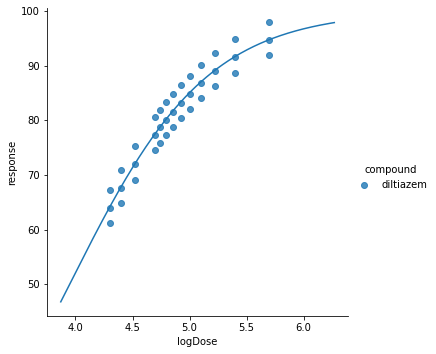

In [331]:
refDose = np.linspace(min(drData.logDose)*0.9,max(drData.logDose)*1.1,256)
refDose = (10**-refDose)*1e6
sns.lmplot('logDose','response',data=drData,hue='compound',fit_reg=False)
for fit in fitData:
    # plt.plot([pDose(i) for i in refDose], [ll4(i,*[fit[i] for i in ['h','a','b','IC50']]) for i in refDose])
    plt.plot([pDose(i) for i in refDose], [ll4(i,*[fit[i] for i in ['h', 'IC50']]) for i in refDose])